## Load all necessary libraries

In [83]:
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D
from keras.applications.resnet50 import preprocess_input
from keras.layers import Dropout, Flatten, Dense
from tensorflow.keras.preprocessing import image  
from keras.callbacks import ModelCheckpoint 
from sklearn.datasets import load_files    
from keras.models import Sequential
from PIL import ImageFile
import tensorflow as tf
from glob import glob
import numpy as np
ImageFile.LOAD_TRUNCATED_IMAGES = True

## Create datasets
Creating training and validating datasets using <code>image_dataset_from_directory</code> that will read all images from given directory and assign labels as names from subdirectories, and reshape images to size (224, 224)

In [84]:
train_dataset = tf.keras.utils.image_dataset_from_directory('dogImages/train/',
                                         image_size = (224,224),
                                         label_mode ='categorical',
                                         batch_size = 32,
                                         seed=123)
validation_dataset = tf.keras.utils.image_dataset_from_directory('dogImages/valid/',
                                         image_size = (224,224),
                                         label_mode ='categorical',
                                         batch_size = 32)

Found 6659 files belonging to 133 classes.
Found 832 files belonging to 133 classes.


In [85]:
#You can see class names as a list
class_names = train_dataset.class_names
class_names = [c[4:] for c in class_names]
class_names[:10]

['Affenpinscher',
 'Afghan_hound',
 'Airedale_terrier',
 'Akita',
 'Alaskan_malamute',
 'American_eskimo_dog',
 'American_foxhound',
 'American_staffordshire_terrier',
 'American_water_spaniel',
 'Anatolian_shepherd_dog']

## Plot our data

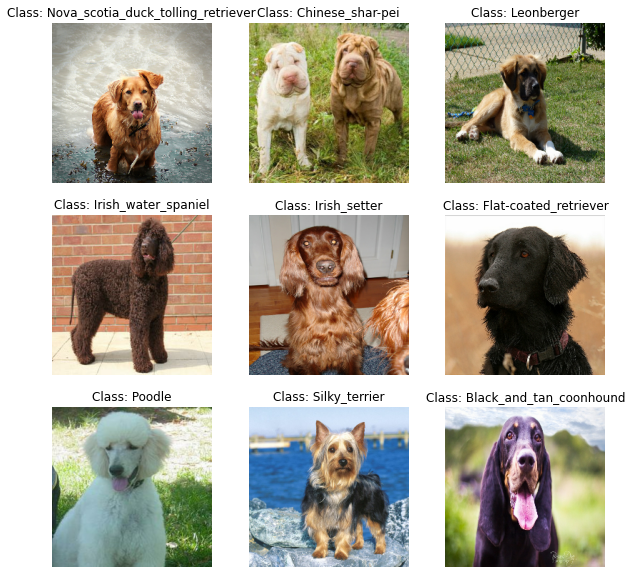

In [86]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_dataset.take(1):
    # Display the first 9 images
    for i in range(9):
        plt.subplot(3, 3, i+1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(f"Class: {class_names[np.argmax(labels[i])]}")
        plt.axis("off")

## Data preprocessing
Before we can feed our images into training the model, first we gonna preprocess images according to Tensorflow documentation. The images are converted from RGB to BGR, then each color channel is zero-centered with respect to the ImageNet dataset, without scaling.

In [87]:
def preprocess(images, labels):
    return tf.keras.applications.resnet50.preprocess_input(images), labels
normalized_train_ds = train_dataset.map(preprocess)
normalized_valid_ds = validation_dataset.map(preprocess)

## Specify ResNet50 as base model for transfer learning
<code>include_top=False</code> - this argument exclude last fully-connected layer from the network allowing us to add our own Dense layer to recognize our classes (dog breeds)

In [88]:
demo_resnet_model = Sequential()

pretrained_model_for_demo= tf.keras.applications.ResNet50(include_top=False,
                   input_shape=(224,224,3),
                   weights='imagenet')
for each_layer in pretrained_model_for_demo.layers:
        each_layer.trainable=False
demo_resnet_model.add(pretrained_model_for_demo)

In [89]:
#Let's see ResNet50 architecture
pretrained_model_for_demo.summary()

Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_4 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 230, 230, 3)          0         ['input_4[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, 112, 112, 64)         9472      ['conv1_pad[0][0]']           
                                                                                                  
 conv1_bn (BatchNormalizati  (None, 112, 112, 64)         256       ['conv1_conv[0][0]']          
 on)                                                                                       

                                                                                                  
 conv2_block3_1_conv (Conv2  (None, 56, 56, 64)           16448     ['conv2_block2_out[0][0]']    
 D)                                                                                               
                                                                                                  
 conv2_block3_1_bn (BatchNo  (None, 56, 56, 64)           256       ['conv2_block3_1_conv[0][0]'] 
 rmalization)                                                                                     
                                                                                                  
 conv2_block3_1_relu (Activ  (None, 56, 56, 64)           0         ['conv2_block3_1_bn[0][0]']   
 ation)                                                                                           
                                                                                                  
 conv2_blo

 ation)                                                                                           
                                                                                                  
 conv3_block2_3_conv (Conv2  (None, 28, 28, 512)          66048     ['conv3_block2_2_relu[0][0]'] 
 D)                                                                                               
                                                                                                  
 conv3_block2_3_bn (BatchNo  (None, 28, 28, 512)          2048      ['conv3_block2_3_conv[0][0]'] 
 rmalization)                                                                                     
                                                                                                  
 conv3_block2_add (Add)      (None, 28, 28, 512)          0         ['conv3_block1_out[0][0]',    
                                                                     'conv3_block2_3_bn[0][0]']   
          

 conv4_block1_2_conv (Conv2  (None, 14, 14, 256)          590080    ['conv4_block1_1_relu[0][0]'] 
 D)                                                                                               
                                                                                                  
 conv4_block1_2_bn (BatchNo  (None, 14, 14, 256)          1024      ['conv4_block1_2_conv[0][0]'] 
 rmalization)                                                                                     
                                                                                                  
 conv4_block1_2_relu (Activ  (None, 14, 14, 256)          0         ['conv4_block1_2_bn[0][0]']   
 ation)                                                                                           
                                                                                                  
 conv4_block1_0_conv (Conv2  (None, 14, 14, 1024)         525312    ['conv3_block4_out[0][0]']    
 D)       

                                                                                                  
 conv4_block3_out (Activati  (None, 14, 14, 1024)         0         ['conv4_block3_add[0][0]']    
 on)                                                                                              
                                                                                                  
 conv4_block4_1_conv (Conv2  (None, 14, 14, 256)          262400    ['conv4_block3_out[0][0]']    
 D)                                                                                               
                                                                                                  
 conv4_block4_1_bn (BatchNo  (None, 14, 14, 256)          1024      ['conv4_block4_1_conv[0][0]'] 
 rmalization)                                                                                     
                                                                                                  
 conv4_blo

 D)                                                                                               
                                                                                                  
 conv4_block6_3_bn (BatchNo  (None, 14, 14, 1024)         4096      ['conv4_block6_3_conv[0][0]'] 
 rmalization)                                                                                     
                                                                                                  
 conv4_block6_add (Add)      (None, 14, 14, 1024)         0         ['conv4_block5_out[0][0]',    
                                                                     'conv4_block6_3_bn[0][0]']   
                                                                                                  
 conv4_block6_out (Activati  (None, 14, 14, 1024)         0         ['conv4_block6_add[0][0]']    
 on)                                                                                              
          

 conv5_block3_1_relu (Activ  (None, 7, 7, 512)            0         ['conv5_block3_1_bn[0][0]']   
 ation)                                                                                           
                                                                                                  
 conv5_block3_2_conv (Conv2  (None, 7, 7, 512)            2359808   ['conv5_block3_1_relu[0][0]'] 
 D)                                                                                               
                                                                                                  
 conv5_block3_2_bn (BatchNo  (None, 7, 7, 512)            2048      ['conv5_block3_2_conv[0][0]'] 
 rmalization)                                                                                     
                                                                                                  
 conv5_block3_2_relu (Activ  (None, 7, 7, 512)            0         ['conv5_block3_2_bn[0][0]']   
 ation)   

Specify two last layers of the model with last layer of the size of number of classes

In [90]:
demo_resnet_model.add(GlobalAveragePooling2D(input_shape=(1,1,2048)))
demo_resnet_model.add(Dense(133, activation='softmax'))

In [91]:
demo_resnet_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),loss='categorical_crossentropy',metrics=['accuracy'])

Save best model weights (lower val_loss) to the file. Warning, this code cell might take a while to complete, if you can use CUDA cores.

In [148]:
from keras.callbacks import ModelCheckpoint 
checkpointer = ModelCheckpoint(filepath='mySavedmodels/weights.best.ResNet50.hdf5', 
                               verbose=1, save_best_only=True)
demo_resnet_model.fit(train_dataset, 
          validation_data=validation_dataset,
          epochs=20, batch_size=32, callbacks=[checkpointer], verbose=1)

Epoch 1/20
333/333 [==============================] - ETA: 0s - loss: 2.4000 - accuracy: 0.4293
Epoch 1: val_loss improved from inf to 1.46794, saving model to mySavedmodels/weights.best.ResNet50.hdf5


/home/patryk/.local/lib/python3.10/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


333/333 [==============================] - 53s 153ms/step - loss: 2.4000 - accuracy: 0.4293 - val_loss: 1.4679 - val_accuracy: 0.5962
Epoch 2/20
333/333 [==============================] - ETA: 0s - loss: 0.7063 - accuracy: 0.8022
Epoch 2: val_loss improved from 1.46794 to 1.31473, saving model to mySavedmodels/weights.best.ResNet50.hdf5
333/333 [==============================] - 47s 141ms/step - loss: 0.7063 - accuracy: 0.8022 - val_loss: 1.3147 - val_accuracy: 0.6202
Epoch 3/20
333/333 [==============================] - ETA: 0s - loss: 0.3453 - accuracy: 0.9189
Epoch 3: val_loss improved from 1.31473 to 1.22787, saving model to mySavedmodels/weights.best.ResNet50.hdf5
333/333 [==============================] - 47s 141ms/step - loss: 0.3453 - accuracy: 0.9189 - val_loss: 1.2279 - val_accuracy: 0.6370
Epoch 4/20
333/333 [==============================] - ETA: 0s - loss: 0.1925 - accuracy: 0.9658
Epoch 4: val_loss improved from 1.22787 to 1.16414, saving model to mySavedmodels/weights.be

Load the best weights to the model

In [92]:
demo_resnet_model.load_weights('mySavedmodels/weights.best.ResNet50.hdf5')

## Test our model

In [93]:
test_dataset = tf.keras.utils.image_dataset_from_directory('dogImages/test/',
                                         image_size = (224,224),
                                         label_mode ='int',
                                         batch_size = 32,
                                         seed=213)

Found 832 files belonging to 133 classes.


Let's see a few photos to visualize what out model predicts

1/1 [==============================] - 0s 28ms/step


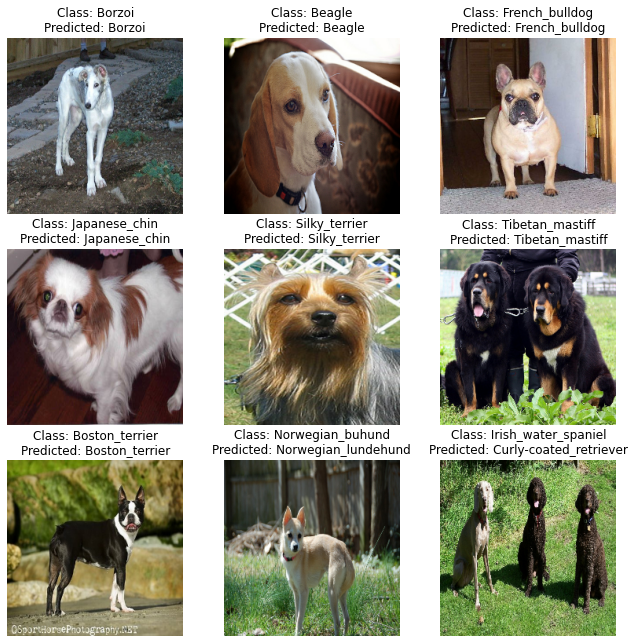

In [173]:
def predict_class(img):
    img = tf.keras.applications.resnet50.preprocess_input(images[i])
    img = np.expand_dims(img, axis=0)
    return np.argmax(demo_resnet_model.predict(img))

plt.figure(figsize=(11, 11))
for images, labels in test_dataset.take(1):
    # Display the first 9 images
    for i in range(9):
        plt.subplot(3, 3, i+1)
        plt.imshow(images[i].numpy().astype("uint8"))
        predicted_class = class_names[predict_class(images[i])]
        plt.title(f"Class: {class_names[labels[i]]}\nPredicted: {predicted_class}")
        plt.axis("off")

## Model accuracy on larger test set

In [97]:
# define function to load test dataset
def load_dataset(path):
    data = load_files(path)
    dog_files = np.array(data['filenames'])
    dog_targets = np.array(data['target'])
    return dog_files, dog_targets

test_files, test_targets = load_dataset('dogImages/test')

def path_to_tensor(img_path):
    # loads RGB image as PIL.Image.Image type
    img = image.load_img(img_path, target_size=(224, 224))
    # convert PIL.Image.Image type to 3D tensor with shape (224, 224, 3)
    x = image.img_to_array(img)
    # convert 3D tensor to 4D tensor with shape (1, 224, 224, 3) and return 4D tensor
    return np.expand_dims(x, axis=0)

In [98]:
def test_resnet50():
    succeeds = 0
    for idx, img_path in enumerate(test_files[:50]):
        img =  preprocess_input(path_to_tensor(img_path))
        prediction = demo_resnet_model.predict(img)
        if np.argmax(prediction) == test_targets[idx]:
            succeeds += 1
    return succeeds / len(test_files[:50])
print(f'Model Accuracy: {test_resnet50() * 100}%')

1/1 [==============================] - 0s 58ms/step


1/1 [==============================] - 0s 58ms/step
Model Accuracy: 81.5%


## Model evaluation on human faces

In [161]:
human_dataset = tf.keras.utils.image_dataset_from_directory('human_faces/',
                                         image_size = (224,224),
                                         label_mode = None,
                                         batch_size = 3,
                                         seed=213)

Found 966 files belonging to 1 classes.


In [162]:
def dog_breed_img(idx):
    class_name = class_names[idx]
    print(class_name)
    files = glob(f'dogImages/test/*{class_name}/*.jpg')
    print(files)
    path = files[0]
    img = image.load_img(path, target_size=(224, 224))
    # convert PIL.Image.Image type to 3D tensor with shape (224, 224, 3)
    x = image.img_to_array(img)
    return x

1/1 [==============================] - 0s 28ms/step
English_toy_spaniel
['dogImages/test/064.English_toy_spaniel/English_toy_spaniel_04508.jpg', 'dogImages/test/064.English_toy_spaniel/English_toy_spaniel_04509.jpg', 'dogImages/test/064.English_toy_spaniel/English_toy_spaniel_04513.jpg', 'dogImages/test/064.English_toy_spaniel/English_toy_spaniel_04532.jpg', 'dogImages/test/064.English_toy_spaniel/English_toy_spaniel_04542.jpg']
1/1 [==============================] - 0s 31ms/step
Lowchen
['dogImages/test/100.Lowchen/Lowchen_06685.jpg', 'dogImages/test/100.Lowchen/Lowchen_06694.jpg', 'dogImages/test/100.Lowchen/Lowchen_06696.jpg', 'dogImages/test/100.Lowchen/Lowchen_06699.jpg']
1/1 [==============================] - 0s 33ms/step
English_springer_spaniel
['dogImages/test/063.English_springer_spaniel/English_springer_spaniel_04440.jpg', 'dogImages/test/063.English_springer_spaniel/English_springer_spaniel_04446.jpg', 'dogImages/test/063.English_springer_spaniel/English_springer_spaniel_04

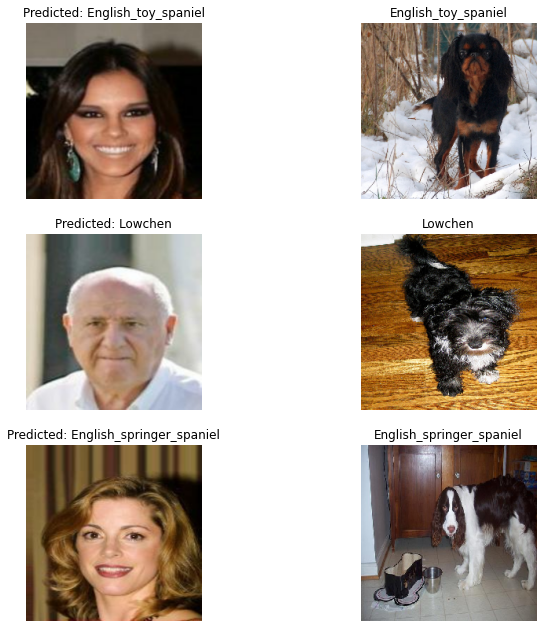

In [179]:
plt.figure(figsize=(11, 11))
for images in human_dataset.take(1):
    # Display the first 9 images
    for i in range(3):
        plt.subplot(3, 2, 2*i+1)
        plt.imshow(images[i].numpy().astype("uint8"))
        predicted_class = predict_class(images[i])
        plt.title(f"Predicted: {class_names[predicted_class]}")
        plt.axis("off")
        plt.subplot(3, 2, 2*i+2)
        plt.imshow(dog_breed_img(predicted_class).astype("uint8"))
        plt.title(f'{class_names[predicted_class]}')
        plt.axis('off')